In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from keras.utils import np_utils
import official.nlp.bert.tokenization as tokenization
from official.nlp import bert
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
# load custom functions
from load_data import load_data, encode_parties
from utils import load_model, evaluate_model, plot_history, predict_class
from bert_functions import encode_names, bert_encode

model_to_load = "bert 1.0_v2"

# load in our model
# create train/test splits and encode our parties
x_train, x_test, Y_train, Y_test = load_data()
y_train, y_test, decoder, encoder = encode_parties(pd.Series(Y_train), pd.Series(Y_test)) # fix this func pls

bert_v1 = load_model(model_to_load, os.getcwd())
# manually create our decoder as I forgot to save it
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(os.getcwd(), model_to_load, 'assets/vocab.txt'),
    do_lower_case=False)

C:\Users\tom_h\AppData\Local\Temp/ipykernel_5032/6206804.py:10: DtypeWarning: Columns (8,10,11,12,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  x_train, x_test, Y_train, Y_test = load_data()


[[2805  627  632]
 [ 445 2931  563]
 [ 392  459 3146]]
                  precision    recall  f1-score   support

    Conservative       0.77      0.69      0.73      4064
          Labour       0.73      0.74      0.74      3939
Liberal Democrat       0.72      0.79      0.75      3997

        accuracy                           0.74     12000
       macro avg       0.74      0.74      0.74     12000
    weighted avg       0.74      0.74      0.74     12000



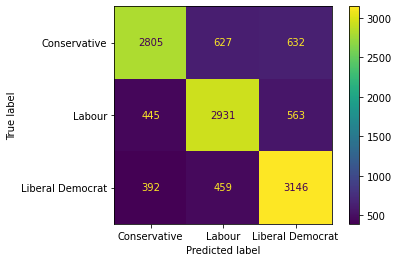

In [3]:
%matplotlib inline
### Accuracy checks!
# check confusion matrices for each class
test_results = bert_v1.predict(bert_encode(x_test, tokenizerSaved, 512))
predicted_categories = tf.argmax(test_results, axis=1)
true_categories = tf.concat(encoder.transform(Y_test), axis=0)
# clean up our predicted and true categories for printing in the matrix...

conf_matrix = confusion_matrix(y_pred = predicted_categories, y_true = true_categories, labels = [0,1,2]) # labels = ['Conservative', 'Labour', 'Liberal Democrat']) # produce our confusion matrix...
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                             display_labels=decoder)
disp.plot() # display our plot graphically
# print report...
print(classification_report(y_pred = predicted_categories, y_true = true_categories, target_names=decoder))

In [5]:
# word version of our confusion matrix
classes, counts = np.unique(np.array(true_categories), return_counts = True)
for i in range(len(decoder)):
    not_i = classes.tolist()
    not_i.pop(i)
    print("Party: ", decoder[i])

    tp = conf_matrix[i,i]
    fn = conf_matrix[i, not_i]
    print("Correctly guessed: ", tp/(sum(fn)+tp)*100, " %")
    print("Total in class: ", str(counts[i]))

    print("True positive: ", str(tp))
    print("True negative: ", str(sum(sum(conf_matrix[not_i, :]))))


    print("False negative: ", sum(fn))
    print("False positive:", sum(conf_matrix[not_i, i]))
    print("") # add whitespace

Party:  Conservative
Correctly guessed:  69.02066929133859  %
Total in class:  4064
True positive:  2805
True negative:  7936
False negative:  1259
False positive: 837

Party:  Labour
Correctly guessed:  74.40974866717441  %
Total in class:  3939
True positive:  2931
True negative:  8061
False negative:  1008
False positive: 1086

Party:  Liberal Democrat
Correctly guessed:  78.70903177383038  %
Total in class:  3997
True positive:  3146
True negative:  8003
False negative:  851
False positive: 1195



In [18]:

### Playing around with our model
bojo_speech = ["the first time we have met since you defied the sceptics by winning councils and communities that Conservatives have never won in before – such as Hartlepool " \
       "in fact it’s the first time since the general election of 2019 when we finally sent the corduroyed communist cosmonaut into orbit where he belongs " \
       "and why are we back today for a traditional Tory cheek by jowler? It is because for months we have had one of the most open economies and societies " \
       "and on July 19 we decided to open every single theatre and every concert hall and night club in England and we knew that some people would still be anxious" \
       "so we sent top government representatives to our sweatiest boites de nuit to show that anyone could dance " \
       "perfectly safely and wasn’t he brilliant my friends? let’s hear it for Jon Bon Govi living proof that we, you all represent the most jiving hip happening and" \
       " generally funkapolitan party in the world and how have we managed to open up ahead of so many of our friends? You know the answer, its " \
       "because of the roll-out of that vaccine a UK phenomenon the magic potion invented in oxford university and bottled in wales " \
       "distributed at incredible speed to vaccination centres everywhere I saw the army in action in Glasgow " \
       "firing staple guns like carbines as they set up a huge vaccination centre and in Fermanagh I saw the needles go in like a collective sewing machine" \
       "and they vaccinated so rapidly that we were able to"]


bojo_input = bert_encode(string_list=list(bojo_speech),
                     tokenizer=tokenizerSaved,
                     max_seq_length=512)

predict_class(bert_v1, bojo_input, decoder) # interestingly, it's extremely confident that this is a Labour speech


[[1.0214136e-03 9.9872559e-01 2.5305507e-04]]
Speech predicted to be: Labour


In [19]:
david_c_speech_1 = ["Conservative policies, policies you campaigned on, policies we are delivering. Two hundred new academies. Ten thousand university places. Fifty thousand apprenticeships." \
                 "Corporation tax – cut. The jobs tax – axed. Police targets – smashed. Immigration – capped. The third runway – stopped. Home Information Packs – dropped. Fat cat salaries – revealed. ID Cards – abolished. The NHS – protected. Our aid promise – kept." \
                 "Quangos – closing down. Ministers' pay – coming down. A bank levy – coming up. A cancer drugs fund – up and running. £6bn of spending saved this year. An emergency budget to balance the books in five years. An EU referendum lock to protect our sovereign powers every year." \
                 "For our pensioners – the earnings link restored. For our new entrepreneurs – employees' tax reduced. And for our brave armed forces – the operational allowance doubled. " \
                 "Look what we've done in five months. Just imagine what we can do in five years. " \
                 "In five years time, our combat troops will have left Afghanistan. This party has steadfastly supported our mission there, and so will this government." \
                 "But that does not mean simply accepting what went before. In our first few weeks in office, we set a clear new direction. Focused. Hard-headed. Time-limited."]

david_c_speech_2 = ["""Corporation tax – cut. The jobs tax – axed. Police targets – smashed. Immigration – capped. The third runway – stopped. Home Information Packs – dropped. Fat cat salaries – revealed. ID Cards – abolished. The NHS – protected. Our aid promise – kept.
Quangos – closing down. Ministers’ pay – coming down. A bank levy – coming up. A cancer drugs fund – up and running. £6bn of spending saved this year. An emergency budget to balance the books in five years. An EU referendum lock to protect our sovereign powers every year.

For our pensioners – the earnings link restored. For our new entrepreneurs – employees’ tax reduced. And for our brave armed forces – the operational allowance doubled.

Look what we’ve done in five months. Just imagine what we can do in five years.

In five years time, our combat troops will have left Afghanistan. This party has steadfastly supported our mission there, and so will this government.

But that does not mean simply accepting what went before. In our first few weeks in office, we set a clear new direction. Focused. Hard-headed. Time-limited.

We are not in Afghanistan to build a perfect democracy. No dreamy ideas. Just hard-headed national security – pure and simple.

Almost every terrorist who took part in 9/11 was trained by al-Qaida in Afghanistan. If we left tomorrow, those training camps could easily come back, because Afghans are not yet capable of securing their own country.

But we will not stay a day longer than we need to. British combat forces will not remain in Afghanistan after 2015."""]

david_c_input_1 = bert_encode(string_list=list(david_c_speech_1),
                     tokenizer=tokenizerSaved,
                     max_seq_length=512)

david_c_input_2 = bert_encode(string_list=list(david_c_speech_2),
                     tokenizer=tokenizerSaved,
                     max_seq_length=512)

print("First cut...")
print(predict_class(bert_v1, david_c_input_1, decoder))

print("Second cut...")
print(predict_class(bert_v1, david_c_input_2, decoder)) # depends heavily on the cut you give it

First cut...
[[0.00122799 0.9976871  0.00108495]]
Speech predicted to be: Labour
None
Second cut...
[[0.9591304  0.0232132  0.01765638]]
Speech predicted to be: Conservative
None


In [20]:
hague_speech = ["""The first is to act in the belief that in a big jungle only big beasts survive; that as markets grow, so must the size of government. We can see this belief driving the way a number of Western European Governments behave, including our own.
They are interfering more and more in the labour market, imposing statutory working hours, levy new taxes and enforcing new regulations in a mistaken belief that this will protect small citizens from the chill winds of the new economy. I say such an approach does not protect citizens. It puts them on the dole. Higher taxes and more regulations only serve to make it that much harder for any business, dot.com or more traditional, to be successful in the global market. Which is why my Party is particularly concerned that business in Britain is having to find £10 billion a year to meet the costs of new regulations and £30 billion of extra business taxes over the lifetime of this Parliament.

I take a different approach, and I suspect many of you do as well.

I believe Governments must recognise that this is the age of the small unit, the individual on the internet, the small business and large business alike using e-commerce, and that in this age it is the low tax, low regulation nation state is best placed to succeed.

For in the dimension-less, go-anywhere world of the new economy, no country can take industry for granted - for industry can go to any country. The common sense approach would be to build on Britain's existing advantages of the English language, our excellent software skills, and our entrepreneurial spirit by keeping government interference to a minimum."""]

hague_input = bert_encode(string_list=list(hague_speech),
                     tokenizer=tokenizerSaved,
                     max_seq_length=512)

predict_class(bert_v1, hague_input, decoder)

[[0.97385436 0.01527647 0.01086912]]
Speech predicted to be: Conservative
